In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel

In [2]:
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

In [3]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 101)

In [4]:
mQ = 0.5

In [5]:
quark_0 = Particle(mQ, qrange, erange, eps=2e-2)
gluon_0 = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)
gluon_0 = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)

In [6]:
T = 0.15
G = 9
L = 0.4
screen = 1.5

## Check the resonance position

In [7]:
ch_quark_test = Channel(quark_0, quark_0, T, G=G, L=L,screen=screen)

In [8]:
ch_quark_test.populate_T()
# ch_quark_test.populate_S()

  0%|          | 0/201 [00:00<?, ?it/s]

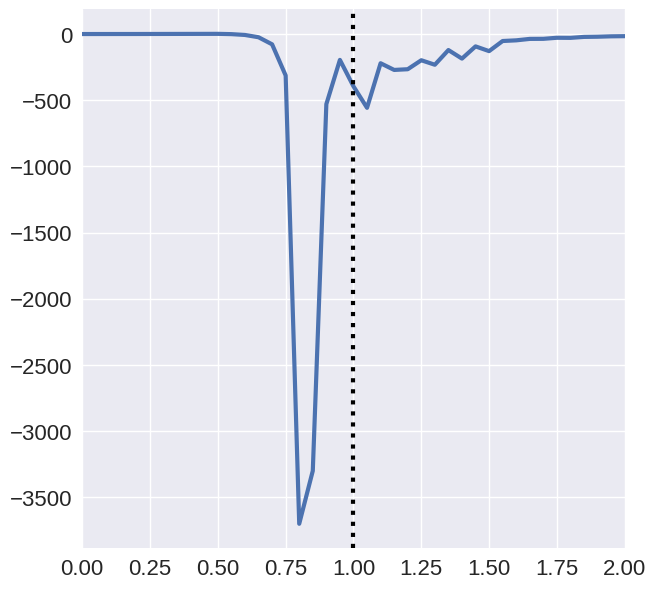

In [9]:
plt.plot(ch_quark_test.erange, imag(ch_quark_test.TM[:, 0]))
plt.xlim(0, 2)
plt.axvline(2*quark_0.m, ls=':', c='black')

In [10]:
ch_quark_test.populate_S()

  0%|          | 0/201 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [207]:
gluon_0 = Particle(1.5, qrange, erange, eps=2e-2, stat='b', d=16)

In [208]:
ch_gluon_test = Channel(gluon_0, gluon_0, T, G=G, Fa=9/4,
                       da=1, ds=16, screen=screen)

In [69]:
ch_gluon_test.populate_T()

  0%|          | 0/201 [00:00<?, ?it/s]

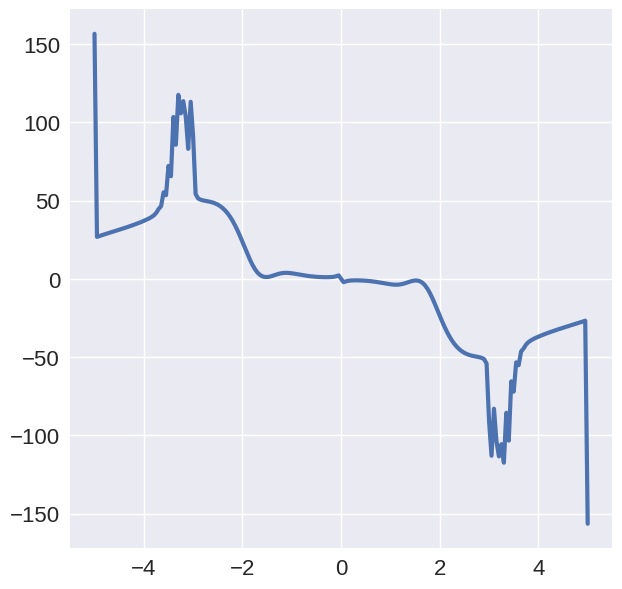

In [71]:
plt.plot(ch_gluon_test.erange, imag(ch_gluon_test.TM[:, 0]))
# plt.xlim(0, 5)

In [72]:
ch_gluon_test.populate_S()

  0%|          | 0/201 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(ch_gluon_test.erange, ch_gluon_test.ImS[:, 0])

## Run iterations in a cycle

In [14]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 51)
quark_run = Particle(mQ, qrange, erange, eps=2e-2)
gluon_run = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)

In [15]:
chss = []
pts = []

delta = 1
T = 0.25

In [38]:
while delta > 1e-4:
#     ch_QQ = Channel(quark_run, quark_run, T, G=G, ds=4, da=1)
#     ch_GG = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4)
#     ch_QG = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8)
#     ch_GQ = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8)
    
#     channels_Q = [ch_QQ, ch_QG]
#     channels_G = [ch_GG, ch_GQ]

    channels_Q = dict()
    
#     channels_Q['qq3'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=3, Fa=1/2, screen=screen)
#     channels_Q['qq6'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=6, Fa=1/4, screen=screen)
    channels_Q['qa1'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=1, Fa=1, screen=screen)
#     channels_Q['qa8'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=8, Fa=1/8, screen=screen)
    
#     channels_Q['qg3'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
#     channels_Q['qg6'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
#     channels_Q['qg15'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)
    
    channels_G = dict()
    
#     channels_G['gq3'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
#     channels_G['gq6'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
#     channels_G['gq15'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)
    
#     channels_G['gg1'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4, screen=screen)
#     channels_G['gg16'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=16, Fa=9/8, screen=screen)
#     channels_G['gg27'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=27, Fa=3/4, screen=screen)
    
    channels = {k : c for k, c in list(channels_G.items()) + list(channels_Q.items())}
    
    for k, ch in channels.items():
        print(k)
        ch.populate_T()
        
        
        ############### dirty parallelization ################
        ress = []
        for q in tqdm.tqdm(ch.qrange):
            res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
            ress += [res]
            
        ress = array(ress).transpose()
        ch.ImS = ress
        
        ReSigmas = []

        for res in tqdm.tqdm(ress.transpose()):
            iImSigma = tm.Interpolator(ch.erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in ch.erange]
            ReSigmas += [ReSigma]

        ch.ReS = np.array(ReSigmas).transpose()
        
        
        ############### Serial version #################
        
#         ch.populate_S()
#     break
        
    ImS_Q = sum([c.ds * c.da * c.ImS / c.p_i.d for k, c in channels_Q.items()], axis=0)
    ReS_Q = sum([c.ds * c.da * c.ReS / c.p_i.d for k, c in channels_Q.items()], axis=0)

    om0_k = np.array([quark_run.om0(quark_run.qrange) for e in quark_run.erange])
    arrE = np.array([quark_run.erange for q in quark_run.qrange]).transpose()

    G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))
    
#     quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, R=-2*imag(G_Q_new))
    quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, Gtab=G_Q_new)
    
    ImS_G = sum([c.ds * c.da *c.ImS / c.p_i.d for c in channels_G.values()],
           axis=0)
    ReS_G = sum([c.ds * c.da *c.ReS / c.p_i.d for c in channels_G.values()],
               axis=0)

    om0_k = np.array([gluon_run.om0(gluon_run.qrange) for e in gluon_run.erange])
    arrE = np.array([gluon_run.erange for q in gluon_run.qrange]).transpose()

#     G_G_new = 1/(arrE**2 - om0_k**2 + 2*1j*gluon_run.eps*arrE - (ReS_G + 1j*ImS_G))
    G_G_new = 1/(arrE - om0_k + 1j*gluon_run.eps - (ReS_G + 1j*ImS_G))
#     gluon_new = Particle(gluon_run.m, qrange, erange, eps=2e-2, stat='b', d=16, R=-2*imag(G_G_new))
    gluon_new = Particle(gluon_run.m, qrange, erange, eps=gluon_run.eps, stat='b', d=16, Gtab=G_G_new)
    
    chss += [[channels_Q, channels_G]]
    pts += [[quark_run, gluon_run]]
    
    delta = 0
    delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
    delta += sqrt(sum((gluon_new.Rtab - gluon_run.Rtab)**2)) / len(erange) / len(qrange)
    delta /= 2
    print(delta)
    
    quark_run = quark_new
    gluon_run = gluon_new
    
    

qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04447004156868413
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04294707822528579
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0371695701943176
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.033811333100986295
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03141762283241501
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.025771738024476028
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.023488738758235476
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.018399371314865933
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.01621632558582271
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.012566175590621382
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.010768365896299292
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.008393055028021035
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fd9e956b240>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7fd9e956b240>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Process ForkPoolWorker-10497:
Process ForkPoolWorker-10498:
Process ForkPoolWorker-10496:
Process ForkPoolWorker-10490:
Process ForkPoolWorker-10493:
Process ForkPoolWorker-10491:
Process ForkPoolWorker-10494:
Process ForkPoolWorker-10495:
Process ForkPoolWorker-10492:
Process ForkPoolWorker-10499:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceba

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/usr/lib/python3.11/site-packages/multiprocess/pool.py

##### Quark self-energies:

In [39]:
n_iter = -1

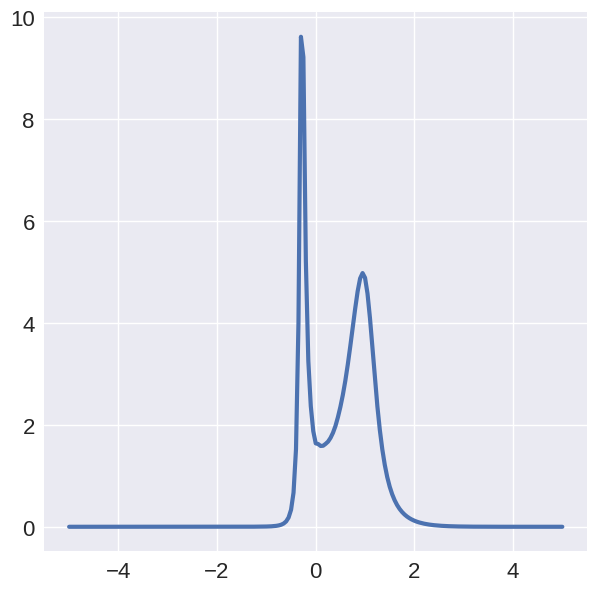

In [40]:
plt.plot(erange, pts[n_iter][0].Rtab[:, 0])

(0.0, 2.0)

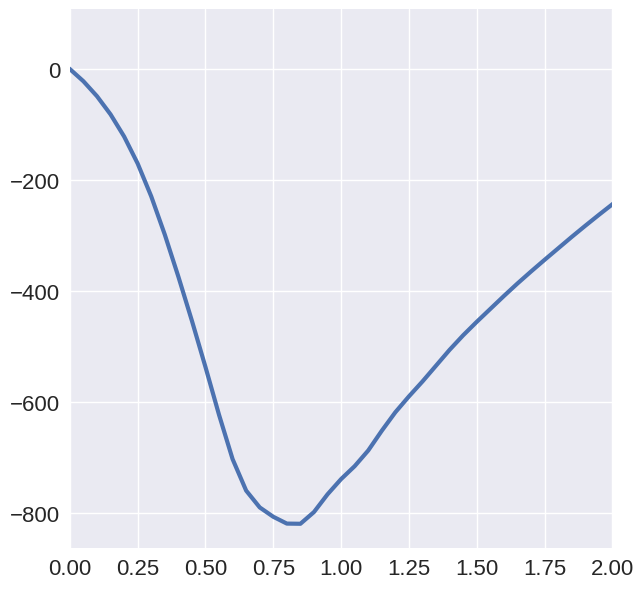

In [41]:
plt.plot(erange, imag(chss[n_iter][0]['qa1'].TM[:, 0]))
plt.xlim(0, 2)

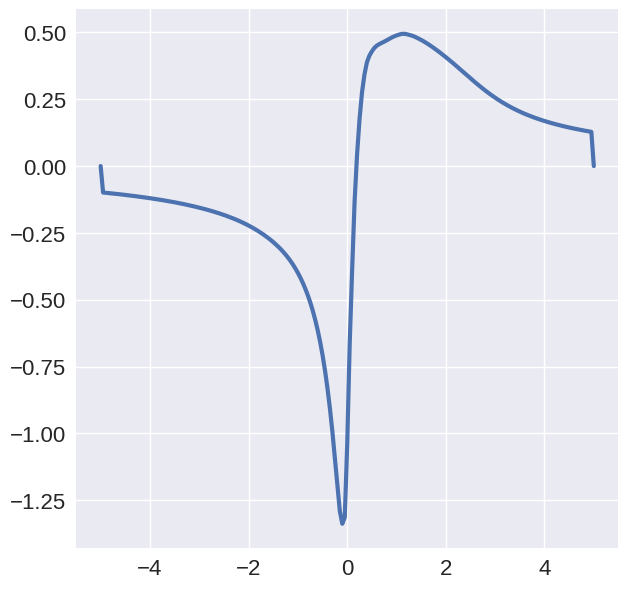

In [42]:
plt.plot(erange, chss[n_iter][0]['qa1'].ReS[:, 0])

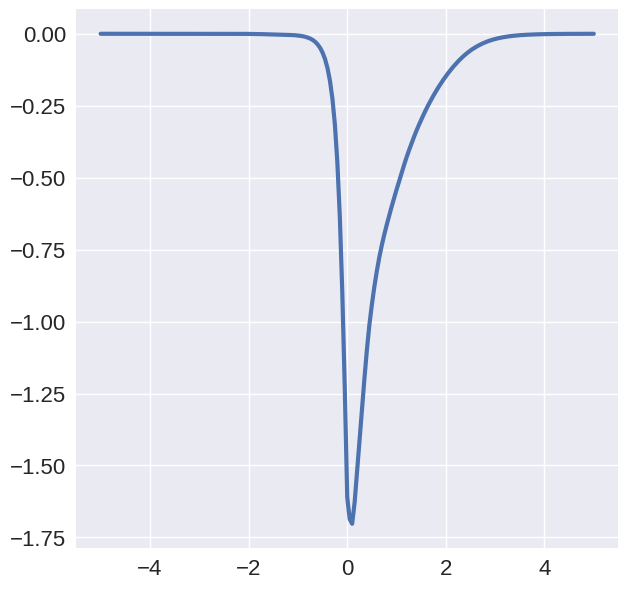

In [43]:
plt.plot(erange, chss[n_iter][0]['qa1'].ImS[:, 0])
# plt.xlim(0, 1)

In [106]:
# chss[0][0]['qa1'].populate_S()
# plt.plot(erange, chss[0][0]['qa1'].ImS[:, 0])

In [101]:
res0 = array([ch.func(z, 0, ch.T, ch.iImT, ch.p_j.R) for z in erange])

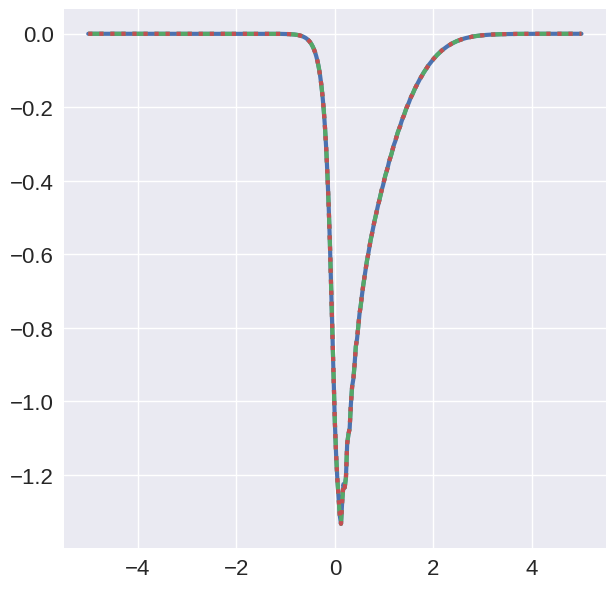

In [102]:
plt.plot(erange, ress[:, 0])
plt.plot(erange, res0, ls='--')
plt.plot(erange, ch.ImS[:, 0], ls=':')

##### Gluon self-energies

In [84]:
n_iter = 0

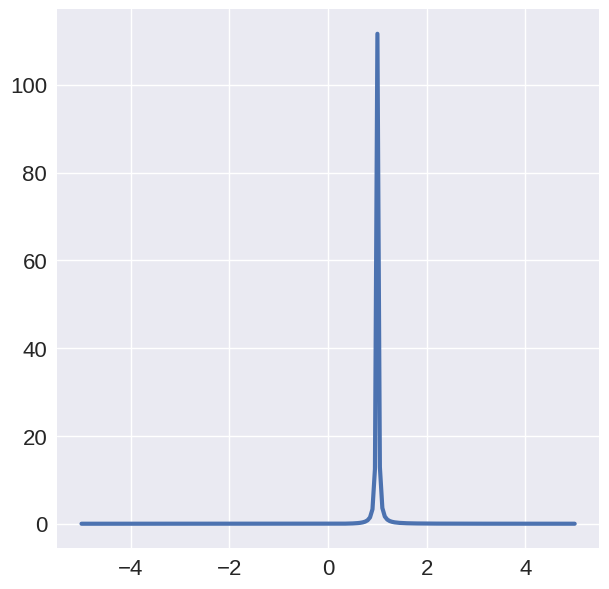

In [85]:
plt.plot(erange, pts[n_iter][1].Rtab[:, 0])

# plt.ylim(-1, 1)

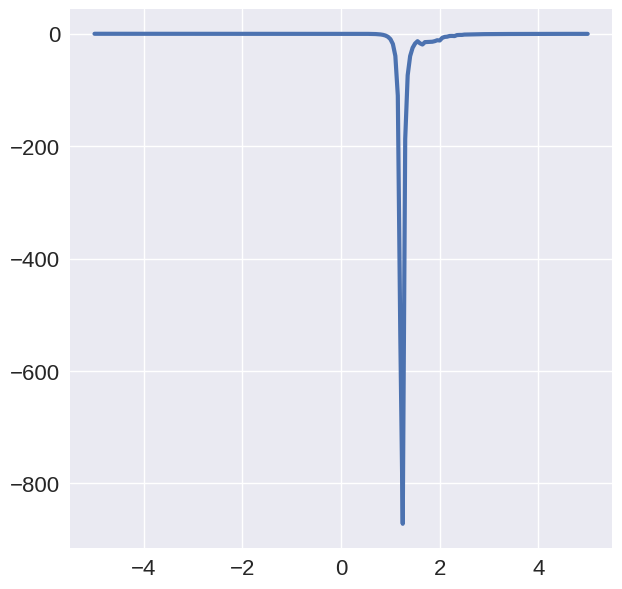

In [86]:
plt.plot(erange, imag(chss[n_iter][1]['gq3'].TM[:, 0]))
# plt.xlim(0, 2)

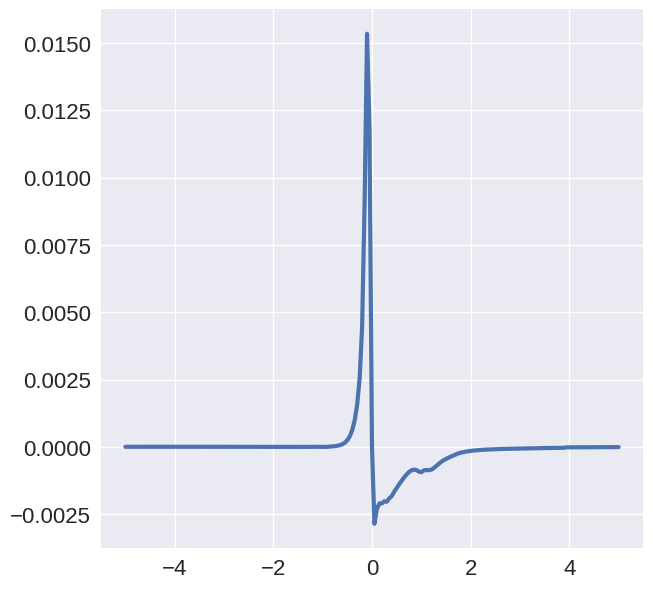

In [87]:
plt.plot(erange, chss[n_iter][1]['gg1'].ImS[:, 0])

In [ ]:
Rtab

##### ====

In [ ]:
chss += [[channels_Q, channels_G]]

(-2000.0, 0.0)

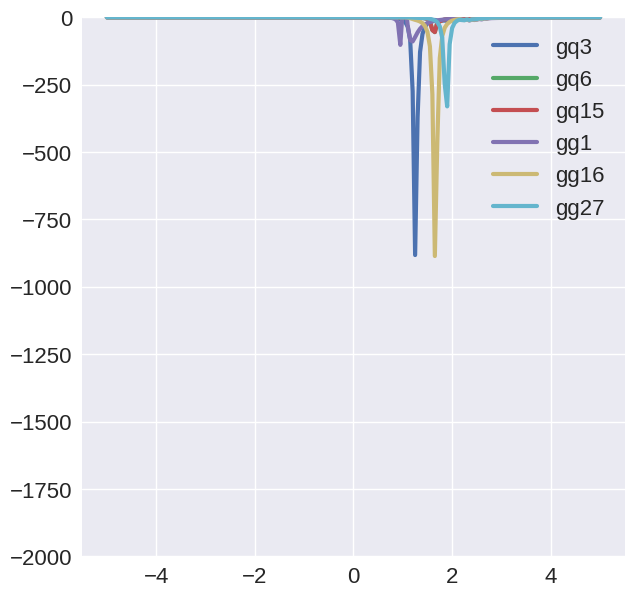

In [61]:
for k, c in chss[0][1].items():
    plt.plot(erange, imag(c.TM[:, 0]), label=k)
    
plt.legend()
plt.ylim(-2000, 0)

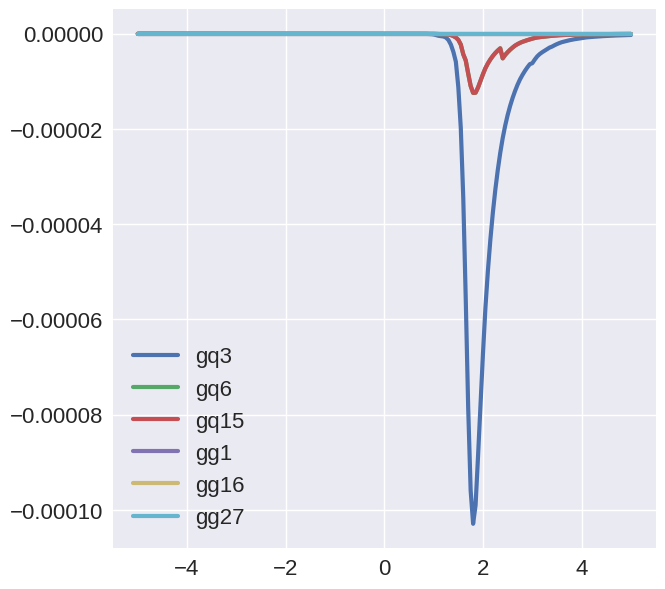

In [62]:
for k, c in chss[-1][1].items():
    plt.plot(erange, c.ImS[:, 0], label=k)
    
plt.legend()

# plt.xlim(-0.5, 0.5)

1.1737009865632435
1.1598540736312284
1.1705497105598273
1.1714647582213435
1.17147346593816
1.1714712100688796
1.1714723229767983
1.1714723301271288


(-1.0, 5.0)

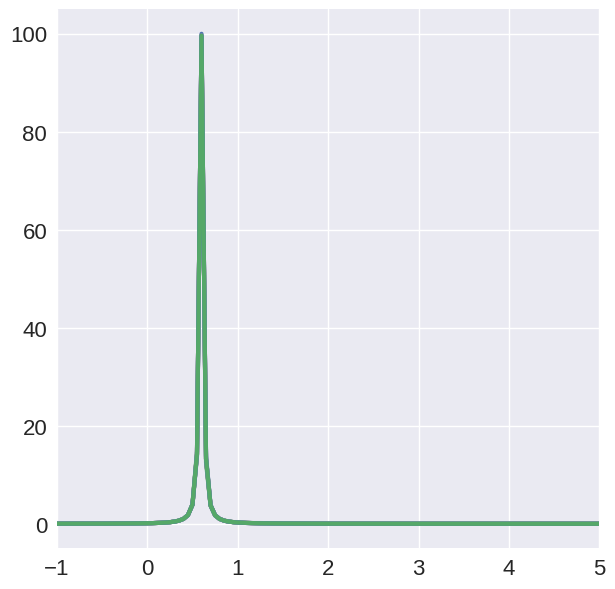

In [63]:
for pt in pts:
    plt.plot(erange, pt[0].Rtab[:, 0])
    print(trapz(pt[0].Rtab[:, 0], x=erange)/2/pi)
    
plt.xlim(-1, 5)
# plt.ylim(0, 30)

1.1736086664353786
0.0965173491227193
0.14900714816332875
6.7472641960734085
6.952906579303587
6.421205638858628
7.163748695538224
6.166601373204766


(0.0, 3.0)

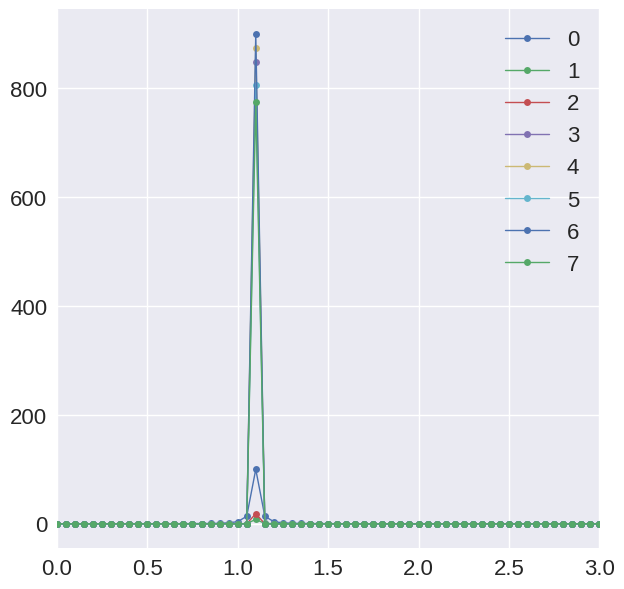

In [64]:
for i, pt in enumerate(pts):
    plt.plot(erange, pt[1].Rtab[:, 0], marker='.', lw=1, label=i)
    print(trapz(pt[1].Rtab[:, 0], x=erange)/2/pi)
    
plt.legend()

plt.xlim(0, 3)

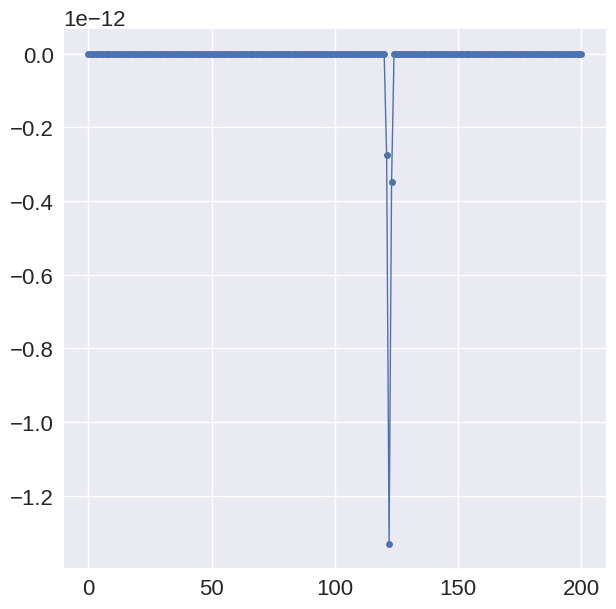

In [65]:
plt.plot(chss[3][1]['gg1'].ImS[:, 0], lw=1, marker='.')

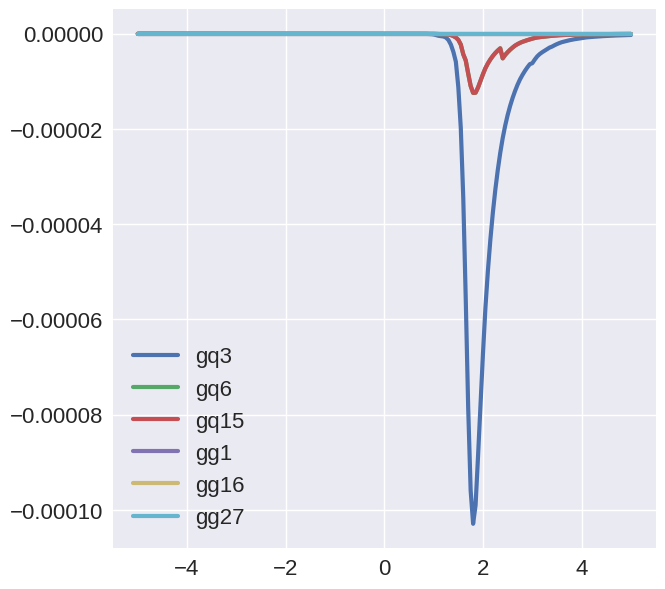

In [66]:
[plt.plot(erange, (c.ImS[:, 0]), label=k) for k, c in chss[-1][1].items()]
plt.legend()

In [162]:
out_folder = 'output/QuarkOnly/'

cQ, cG = chss[0]


for k, c in cQ.items():
    np.savetxt(out_folder + 'Q_TM_'+k+'_T=%.3f.dat'%T, c.TM)
    np.savetxt(out_folder + 'Q_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
    np.savetxt(out_folder + 'Q_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)

for k, c in cG.items():
    np.savetxt(out_folder + 'G_TM_'+k+'_T=%.3f.dat'%T, c.TM)
    np.savetxt(out_folder + 'G_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
    np.savetxt(out_folder + 'G_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)
        
    

np.savetxt(out_folder + 'Q_Rho_T=%.3f.dat'%T, pts[-1][0].Rtab)
np.savetxt(out_folder + 'G_Rho_T=%.3f.dat'%T, pts[-1][1].Rtab)

np.savetxt(out_folder + 'Q_G_T=%.3f.dat'%T, pts[-1][0].Gtab)
np.savetxt(out_folder + 'G_G_T=%.3f.dat'%T, pts[-1][1].Gtab)

np.savetxt(out_folder + 'erange_T=%.3f.dat'%T, erange)
np.savetxt(out_folder + 'qrange_T=%.3f.dat'%T, qrange)



In [142]:
channels_Q.keys()

dict_keys(['qq3', 'qq6', 'qa1', 'qa8', 'qg3', 'qg6', 'qg15'])

## Iterate over temperatures too

In [10]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 51)

eps = 2e-2
quark_run = Particle(mQ, qrange, erange, eps=eps)
gluon_run = Particle(1.5, qrange, erange, eps=eps, stat='b', d=16)

In [11]:
import os

In [12]:
out_folder = 'output/QuarkOnly_X_1ch_test4pi_onshell/'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [13]:
Trange = arange(0.2, 0.65, 0.05)

In [14]:
quark_run.d

6

In [18]:
for T in Trange:

    chss = []
    pts = []

    delta = 1

    while delta > 1e-3:
    #     ch_QQ = Channel(quark_run, quark_run, T, G=G, ds=4, da=1)
    #     ch_GG = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4)
    #     ch_QG = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8)
    #     ch_GQ = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8)

    #     channels_Q = [ch_QQ, ch_QG]
    #     channels_G = [ch_GG, ch_GQ]

        channels_Q = dict()

#         channels_Q['qq3'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=3, Fa=1/2, screen=screen)
#         channels_Q['qq6'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=6, Fa=1/4, screen=screen)
        channels_Q['qa1'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=1, Fa=1, screen=screen)
#         channels_Q['qa8'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=8, Fa=1/8, screen=screen)

#         channels_Q['qg3'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
    #     channels_Q['qg6'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
    #     channels_Q['qg15'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)

        channels_G = dict()

#         channels_G['gq3'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
    #     channels_G['gq6'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
    #     channels_G['gq15'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)

#         channels_G['gg1'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4, screen=screen)
    #     channels_G['gg16'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=16, Fa=9/8, screen=screen)
    #     channels_G['gg27'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=27, Fa=3/4, screen=screen)

        channels = {k : c for k, c in list(channels_G.items()) + list(channels_Q.items())}

        for k, ch in channels.items():
            np.savetxt(out_folder + f'{k}_vq.dat', ch.v(ch.qrange))
            np.savetxt(out_folder + f'{k}_weights', array([ch.ds, ch.da, ch.Fa]))
        
        for k, ch in channels.items():
            print(k)
            ch.populate_T()
            
            

            ############### dirty parallelization ################
            ress = []
            for q in tqdm.tqdm(ch.qrange):
                if ch.func != tm.sigma_ff_onshell:
                    res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
                    ress += [res]
                else:
                    eps1 = tm.Interpolator(ch.qrange, ch.p_i.om0(ch.qrange), 'linear')
                    eps2 = tm.Interpolator(ch.qrange, ch.p_j.om0(ch.qrange), 'linear')
                    res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, 
                                                                ch.p_j.R, eps1, eps2)]*(NTHR//1) | END
                    ress += [res]

            ress = array(ress).transpose()
            ch.ImS = ress

            ReSigmas = []

            for res in tqdm.tqdm(ress.transpose()):
                iImSigma = tm.Interpolator(ch.erange, np.ascontiguousarray(res), 'cubic')
                ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in ch.erange]
                ReSigmas += [ReSigma]

            ch.ReS = np.array(ReSigmas).transpose()


            ############### Serial version #################

    #         ch.populate_S()
    #     break

        ImS_Q = sum([c.ds * c.da * c.ImS / c.p_i.d for k, c in channels_Q.items()], axis=0)
        ReS_Q = sum([c.ds * c.da * c.ReS / c.p_i.d for k, c in channels_Q.items()], axis=0)

        om0_k = np.array([quark_run.om0(quark_run.qrange) for e in quark_run.erange])
        arrE = np.array([quark_run.erange for q in quark_run.qrange]).transpose()

        G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))

    #     quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, R=-2*imag(G_Q_new))
        quark_new = Particle(quark_run.m, qrange, erange, eps=quark_run.eps, Gtab=G_Q_new)
        
        quark_new.S = ReS_Q + 1j*ImS_Q
        
        ImS_G = sum([c.ds * c.da *c.ImS / c.p_i.d for c in channels_G.values()],
               axis=0)
        
        ReS_G = sum([c.ds * c.da *c.ReS / c.p_i.d for c in channels_G.values()],
               axis=0)

        om0_k = np.array([gluon_run.om0(gluon_run.qrange) for e in gluon_run.erange])
        arrE = np.array([gluon_run.erange for q in gluon_run.qrange]).transpose()

    #     G_G_new = 1/(arrE**2 - om0_k**2 + 2*1j*gluon_run.eps*arrE - (ReS_G + 1j*ImS_G))
        G_G_new = 1/(arrE - om0_k + 1j*gluon_run.eps - (ReS_G + 1j*ImS_G))
    #     gluon_new = Particle(gluon_run.m, qrange, erange, eps=2e-2, stat='b', d=16, R=-2*imag(G_G_new))
        gluon_new = Particle(gluon_run.m, qrange, erange, eps=gluon_run.eps, stat='b', d=16, Gtab=G_G_new)
        
        gluon_new.S = ReS_G + 1j*ImS_G
        
        chss += [[channels_Q, channels_G]]
        pts += [[quark_run, gluon_run]]

        delta = 0
        delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
#         delta += sqrt(sum((gluon_new.Rtab - gluon_run.Rtab)**2)) / len(erange) / len(qrange)
        delta /= 2
        print(delta)

        quark_run = quark_new
        gluon_run = gluon_new

    cQ, cG = chss[-1]

    for k, c in cQ.items():
        np.savetxt(out_folder + 'Q_TM_'+k+'_T=%.3f.dat'%T, c.TM)
        np.savetxt(out_folder + 'Q_X_'+k+'_T=%.3f.dat'%T, c.X)
        np.savetxt(out_folder + 'Q_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
        np.savetxt(out_folder + 'Q_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)

    for k, c in cG.items():
        np.savetxt(out_folder + 'G_TM_'+k+'_T=%.3f.dat'%T, c.TM)
#         np.savetxt(out_folder + 'G_X_'+k+'_T=%.3f.dat'%T, c.X)
        np.savetxt(out_folder + 'G_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
        np.savetxt(out_folder + 'G_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)



    np.savetxt(out_folder + 'Q_Rho_T=%.3f.dat'%T, pts[-1][0].Rtab)
    np.savetxt(out_folder + 'G_Rho_T=%.3f.dat'%T, pts[-1][1].Rtab)

    np.savetxt(out_folder + 'Q_G_T=%.3f.dat'%T, pts[-1][0].Gtab)
    np.savetxt(out_folder + 'G_G_T=%.3f.dat'%T, pts[-1][1].Gtab)
    
    np.savetxt(out_folder + 'Q_S_T=%.3f.dat'%T, pts[-1][0].S)
#     np.savetxt(out_folder + 'G_S_T=%.3f.dat'%T, pts[-1][1].S)

    np.savetxt(out_folder + 'erange_T=%.3f.dat'%T, erange)
    np.savetxt(out_folder + 'qrange_T=%.3f.dat'%T, qrange)

qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03609658451597463
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.022765657272499348
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.009539367748193563
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.00398454484588037
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0018262962296457864
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0010031097237670887
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0008199612991842786
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.006775530446245716
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.003616655730501852
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.00186963927030038
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0009577931833644016
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.005621216869682892
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0027761613785036447
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0014424169228976734
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0007964149235353799
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.004754857781659575
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.001317191582650076
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0004971184601824176
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0032088204447743613
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0005215494435530097
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0020201692969783027
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0016311325604871205
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0011053813770313223
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0005353224709890638
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.001465064705457215
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0021635803484645723
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0012132050726234918
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.00048712713119023675
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0016917855107018414
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0024768086758103153
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0011530890433116717
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0003690731224222105
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.002189692166400057
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.002492244808978549
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0009661556288808207


In [43]:
any(quark_run.Rtab == nan)

False

In [44]:
gluon_run.S

0j

In [37]:
pts[-1][0].Gtab

/tmp/ipykernel_45215/3823240954.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qrange, 1 / (1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.plot(qrange, -1/qrange * log(1 - qrange))


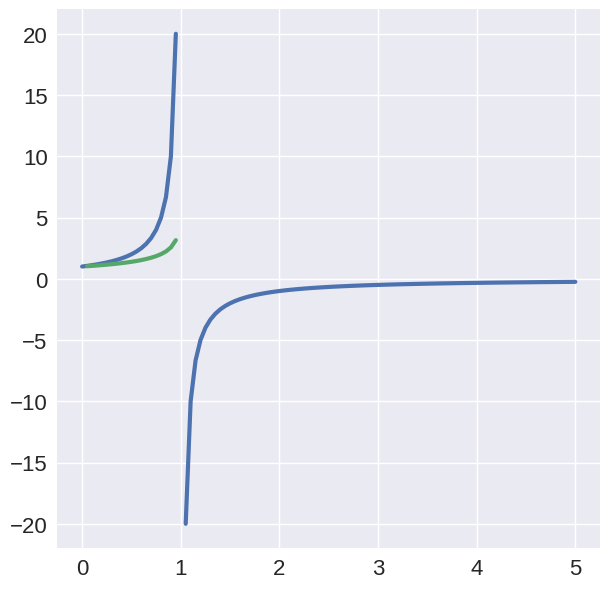

In [19]:
plt.plot(qrange, 1 / (1 - qrange))
plt.plot(qrange, -1/qrange * log(1 - qrange))
